# Modelagem e previsão.

O objetivo deste documento é tratar e criar modelos que possibilitam a previsão aproximada do valor dos carros com base em características pré-estabelecidas, utilizando os dados disponibilizados para criar o modelo. A variável a ser prevista é o preço dos veículos, uma variável quantitativa contínua. Portanto, uma solução de classificação não seria suficiente, embora para carros novos, com preço fixo, pudesse ser utilizada uma classificação multiclasse. No cenário atual deste problema, serão abordadas apenas técnicas de regressão. Foi utilizada uma abordagem simples, mas certamente um estudo mais minucioso de cada variável levaria a modelos mais complexos.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('./cars_train.csv', encoding='utf-16', sep='\t')
test = pd.read_csv('./cars_test.csv', encoding='utf-16', sep='\t')

A variável `id` não possui significado para o modelo em questão e será descartada. 

In [2]:
df.drop('id', axis=1, inplace=True)

Sabe-se que há poucas opções para lidar com as variáveis quantitativas conforme estão. Portanto, optou-se por transformá-las em variáveis qualitativas utilizando a técnica de codificação One Hot Encoder. As colunas com sufixo "_nan" serão removidas. Observou-se também que a variável "veiculo_alienado" consiste totalmente de valores ausentes (NaN), portanto, será removida. Além disso, a coluna "preco" será removida, uma vez que não é necessário aplicar transformações imediatas a ela, as colunas modelo, cidade do vendedor e versão serão convertidas em valores numéricos sem One-Hote Encoder, pois irão gerar muitas colunas na codificação.

In [3]:
def QualiNum(data, ref: bool = None, index: int = 0, ignore: list = None):
    data = data.copy() 
    columns_name = data.columns
    if ignore:
        columns_name = columns_name[~columns_name.isin(ignore)]
        
    for cl in columns_name:
        names_col = data[cl].unique()
        if not pd.api.types.is_numeric_dtype(data[cl]):
            if ref:
                data.insert(loc=data.columns.get_loc(cl)+1, column=cl+'_object', value=data[cl])  
            for i in range(len(names_col)):
                data.loc[data[cl] == names_col[i], cl] = i + index   
            data[cl] = pd.to_numeric(data[cl], errors='ignore')
    
    return data


Para evitar categorias desconhecidas no pipeline, é necessário juntar os conjuntos de dados de treinamento e teste. Dessa forma, todas as categorias presentes nos dados de teste serão consideradas durante o ajuste do pipeline.

In [4]:
df_new =  pd.concat([df, test], axis=0)

In [5]:
data_ref = QualiNum(df_new[['modelo', 'versao', 'cidade_vendedor']], ref=True)
data_ref.nunique()

modelo                     473
modelo_object              473
versao                    2058
versao_object             2058
cidade_vendedor            648
cidade_vendedor_object     648
dtype: int64

As variáveis qualitativas e quantitativas serão separadas e técnicas de pré-processamento distintas serão aplicadas a cada uma delas, antes de prosseguir para os modelos propriamente ditos.

In [6]:
df_quali = df_new.select_dtypes(exclude=['number'])
df_quanti = df_new.select_dtypes(include=['number'])
print(df_quali.columns)
print(df_quanti.columns)

Index(['marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'anunciante',
       'entrega_delivery', 'troca', 'elegivel_revisao', 'dono_aceita_troca',
       'veiculo_único_dono', 'revisoes_concessionaria', 'ipva_pago',
       'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda',
       'id'],
      dtype='object')
Index(['num_fotos', 'ano_de_fabricacao', 'ano_modelo', 'hodometro',
       'num_portas', 'veiculo_alienado', 'preco'],
      dtype='object')


In [7]:
df_quanti.drop(['veiculo_alienado', 'preco'], axis=1, inplace=True)
df_quali.drop(['modelo', 'versao', 'cidade_vendedor', 'id'], axis=1, inplace=True)
df_quanti[['modelo', 'versao', 'cidade_vendedor']] = data_ref[['modelo', 'versao', 'cidade_vendedor']]
df_new[['modelo', 'versao', 'cidade_vendedor']] = data_ref[['modelo', 'versao', 'cidade_vendedor']]

Será criado um pipeline que permite reproduzir, com facilidade, os tratamentos de dados realizados. Nos pipelines a seguir, os dados faltantes nas variáveis quantitativas serão preenchidos com a média dos valores, enquanto para as variáveis qualitativas será aplicada a técnica de One-hot Encoder, que permite a conversão de variáveis qualitativas em representações numéricas. Em seguida, será aplicada uma padronização nos dados. A padronização ajusta os valores para que tenham média zero e variância um, permitindo comparações justas entre diferentes variáveis.

In [8]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer

In [9]:
quantiPipeline = Pipeline([('imputer', SimpleImputer(strategy = "median", add_indicator = False)), ('std_scaler', StandardScaler())])
qualiPipeline = Pipeline([('ohe', OneHotEncoder(sparse = False)), ('std_scaler', StandardScaler())]) 
fullPipeline = ColumnTransformer([("quanti", quantiPipeline, df_quanti.columns), ("quali", qualiPipeline, df_quali.columns)]) 
fullPipeline

ColumnTransformer(transformers=[('quanti',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 Index(['num_fotos', 'ano_de_fabricacao', 'ano_modelo', 'hodometro',
       'num_portas', 'modelo', 'versao', 'cidade_vendedor'],
      dtype='object')),
                                ('quali',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(sparse=False)),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 Index(['marca', 'cambio', 'tipo', 'blindado', 'cor', 'tipo_vendedor',
       'estado_vendedor', 'anunciante', 'entrega_delivery', 'troca',
       'elegivel_revisao', 'dono_aceita_troca', 'veiculo_único_dono',
       'revisoes_concessionaria', 'ipva_pago', 'veiculo_licenciado',
       'garantia_de_fábrica', 'revisoes_dentro_agenda'],
      dtype='object'))])

In [10]:
train = pd.DataFrame(fullPipeline.fit_transform(df_new), columns=fullPipeline.get_feature_names_out())

C:\Users\Dante\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
train = train.drop(range(len(df['ano_de_fabricacao']), len(train['quali__cambio_CVT'])))

In [12]:
train

,quanti__num_fotos,quanti__ano_de_fabricacao,quanti__ano_modelo,quanti__hodometro,quanti__num_portas,quanti__modelo,quanti__versao,quanti__cidade_vendedor,quali__marca_ALFA ROMEO,quali__marca_AUDI,...,quali__revisoes_concessionaria_Todas as revisões feitas pela concessionária,quali__revisoes_concessionaria_nan,quali__ipva_pago_IPVA pago,quali__ipva_pago_nan,quali__veiculo_licenciado_Licenciado,quali__veiculo_licenciado_nan,quali__garantia_de_fábrica_Garantia de fábrica,quali__garantia_de_fábrica_nan,quali__revisoes_dentro_agenda_Todas as revisões feitas pela agenda do carro,quali__revisoes_dentro_agenda_nan
0,-0.664673,0.061660,-0.301706,0.288539,0.174568,-0.942036,-0.819231,-0.392490,-0.015924,-0.248316,...,1.490965,-1.490965,0.710107,-0.710107,0.925355,-0.925355,-0.414687,0.414687,-0.500547,0.500547
1,-0.664673,0.061660,-0.301706,0.141254,0.174568,-0.928631,-0.816757,-0.377201,-0.015924,-0.248316,...,-0.670707,0.670707,0.710107,-0.710107,-1.080666,1.080666,-0.414687,0.414687,-0.500547,0.500547
2,1.637358,0.306475,0.445874,-0.439803,0.174568,-0.915227,-0.814283,-0.361912,-0.015924,-0.248316,...,-0.670707,0.670707,-1.408238,1.408238,-1.080666,1.080666,-0.414687,0.414687,-0.500547,0.500547
3,1.061850,-0.917602,-1.049286,0.828912,0.174568,-0.901823,-0.811809,-0.346622,-0.015924,-0.248316,...,-0.670707,0.670707,0.710107,-0.710107,0.925355,-0.925355,-0.414687,0.414687,-0.500547,0.500547
4,-0.664673,-0.917602,-1.049286,0.402821,0.174568,-0.888419,-0.809335,-0.392490,-0.015924,-0.248316,...,1.490965,-1.490965,-1.408238,1.408238,-1.080666,1.080666,2.411459,-2.411459,1.997816,-1.997816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29579,-0.664673,1.040922,1.193454,-1.543595,0.174568,-0.057353,0.655348,-0.285465,-0.015924,-0.248316,...,-0.670707,0.670707,0.710107,-0.710107,0.925355,-0.925355,2.411459,-2.411459,-0.500547,0.500547
29580,-0.664673,0.796106,0.819664,-1.241312,0.174568,-0.740971,-0.737585,0.219082,-0.015924,-0.248316,...,1.490965,-1.490965,0.710107,-0.710107,0.925355,-0.925355,2.411459,-2.411459,-0.500547,0.500547
29581,-0.664673,0.551291,0.445874,-0.419153,0.174568,-0.057353,-0.396156,1.640987,-0.015924,-0.248316,...,-0.670707,0.670707,-1.408238,1.408238,-1.080666,1.080666,-0.414687,0.414687,-0.500547,0.500547
29582,-0.664673,1.040922,1.567243,-0.706963,0.174568,-0.191396,-0.660887,-0.392490,-0.015924,-0.248316,...,-0.670707,0.670707,0.710107,-0.710107,0.925355,-0.925355,-0.414687,0.414687,-0.500547,0.500547


In [13]:
def nan_sufix(lista, nan):
    lists = []
    for coluna in lista:
        if nan in coluna:
            lists.append(coluna)
    return lists
nan_list = list(nan_sufix(train.columns, '_nan'))
nan_list

['quali__dono_aceita_troca_nan',
 'quali__veiculo_único_dono_nan',
 'quali__revisoes_concessionaria_nan',
 'quali__ipva_pago_nan',
 'quali__veiculo_licenciado_nan',
 'quali__garantia_de_fábrica_nan',
 'quali__revisoes_dentro_agenda_nan']

In [14]:
train.drop(nan_list, axis=1, inplace=True)
train.head(2)

,quanti__num_fotos,quanti__ano_de_fabricacao,quanti__ano_modelo,quanti__hodometro,quanti__num_portas,quanti__modelo,quanti__versao,quanti__cidade_vendedor,quali__marca_ALFA ROMEO,quali__marca_AUDI,...,quali__troca_False,quali__troca_True,quali__elegivel_revisao_False,quali__dono_aceita_troca_Aceita troca,quali__veiculo_único_dono_Único dono,quali__revisoes_concessionaria_Todas as revisões feitas pela concessionária,quali__ipva_pago_IPVA pago,quali__veiculo_licenciado_Licenciado,quali__garantia_de_fábrica_Garantia de fábrica,quali__revisoes_dentro_agenda_Todas as revisões feitas pela agenda do carro
0,-0.664673,0.06166,-0.301706,0.288539,0.174568,-0.942036,-0.819231,-0.392490,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,-1.691508,-0.737561,1.490965,0.710107,0.925355,-0.414687,-0.500547
1,-0.664673,0.06166,-0.301706,0.141254,0.174568,-0.928631,-0.816757,-0.377201,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,0.591189,-0.737561,-0.670707,0.710107,-1.080666,-0.414687,-0.500547


In [15]:
train.isna().sum().sort_values()

quanti__num_fotos                                                              0
quali__estado_vendedor_Mato Grosso (MT)                                        0
quali__estado_vendedor_Maranhão (MA)                                           0
quali__estado_vendedor_Goiás (GO)                                              0
quali__estado_vendedor_Espírito Santo (ES)                                     0
                                                                              ..
quali__marca_MASERATI                                                          0
quali__marca_LIFAN                                                             0
quali__marca_LEXUS                                                             0
quali__marca_SSANGYONG                                                         0
quali__revisoes_dentro_agenda_Todas as revisões feitas pela agenda do carro    0
Length: 117, dtype: int64

In [16]:
#Adicionando novamente os preços
train['preco'] =  df['preco']

In [17]:
train

,quanti__num_fotos,quanti__ano_de_fabricacao,quanti__ano_modelo,quanti__hodometro,quanti__num_portas,quanti__modelo,quanti__versao,quanti__cidade_vendedor,quali__marca_ALFA ROMEO,quali__marca_AUDI,...,quali__troca_True,quali__elegivel_revisao_False,quali__dono_aceita_troca_Aceita troca,quali__veiculo_único_dono_Único dono,quali__revisoes_concessionaria_Todas as revisões feitas pela concessionária,quali__ipva_pago_IPVA pago,quali__veiculo_licenciado_Licenciado,quali__garantia_de_fábrica_Garantia de fábrica,quali__revisoes_dentro_agenda_Todas as revisões feitas pela agenda do carro,preco
0,-0.664673,0.061660,-0.301706,0.288539,0.174568,-0.942036,-0.819231,-0.392490,-0.015924,-0.248316,...,-0.452577,0.0,-1.691508,-0.737561,1.490965,0.710107,0.925355,-0.414687,-0.500547,74732.590084
1,-0.664673,0.061660,-0.301706,0.141254,0.174568,-0.928631,-0.816757,-0.377201,-0.015924,-0.248316,...,-0.452577,0.0,0.591189,-0.737561,-0.670707,0.710107,-1.080666,-0.414687,-0.500547,81965.332634
2,1.637358,0.306475,0.445874,-0.439803,0.174568,-0.915227,-0.814283,-0.361912,-0.015924,-0.248316,...,-0.452577,0.0,0.591189,-0.737561,-0.670707,-1.408238,-1.080666,-0.414687,-0.500547,162824.814472
3,1.061850,-0.917602,-1.049286,0.828912,0.174568,-0.901823,-0.811809,-0.346622,-0.015924,-0.248316,...,2.209569,0.0,0.591189,-0.737561,-0.670707,0.710107,0.925355,-0.414687,-0.500547,123681.358857
4,-0.664673,-0.917602,-1.049286,0.402821,0.174568,-0.888419,-0.809335,-0.392490,-0.015924,-0.248316,...,-0.452577,0.0,-1.691508,-0.737561,1.490965,-1.408238,-1.080666,2.411459,1.997816,82419.763891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29579,-0.664673,1.040922,1.193454,-1.543595,0.174568,-0.057353,0.655348,-0.285465,-0.015924,-0.248316,...,-0.452577,0.0,0.591189,1.355821,-0.670707,0.710107,0.925355,2.411459,-0.500547,403015.289616
29580,-0.664673,0.796106,0.819664,-1.241312,0.174568,-0.740971,-0.737585,0.219082,-0.015924,-0.248316,...,-0.452577,0.0,-1.691508,1.355821,1.490965,0.710107,0.925355,2.411459,-0.500547,88978.080497
29581,-0.664673,0.551291,0.445874,-0.419153,0.174568,-0.057353,-0.396156,1.640987,-0.015924,-0.248316,...,-0.452577,0.0,0.591189,-0.737561,-0.670707,-1.408238,-1.080666,-0.414687,-0.500547,218807.648664
29582,-0.664673,1.040922,1.567243,-0.706963,0.174568,-0.191396,-0.660887,-0.392490,-0.015924,-0.248316,...,-0.452577,0.0,0.591189,1.355821,-0.670707,0.710107,0.925355,-0.414687,-0.500547,68495.990693


In [18]:
#Separando dados de treino 95% e teste 5%.
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size = 0.05, random_state = 123)
x_train = train.drop(['preco'], axis=1)
y_train = train['preco']
preco_real = test['preco']
test.drop(['preco'], axis=1, inplace=True)

# Modelos

Alguns testes foram realizados e optou-se por trabalhar com modelos definidos manualmente. Alguns desses modelos foram treinados utilizando algoritmos como GridSearch e RandomSearch e estão disponíveis na pasta "models". No entanto, devido ao alto custo computacional e aos resultados insatisfatórios obtidos para o problema em questão, não foi possível utilizar a métrica de acurácia. Por isso, recorreu-se principalmente ao R2_score, por ser uma medida de fácil compreensão. No entanto, para evitar que a medida de desempenho seja influenciada, também foi realizada uma análise de erro usando duas métricas de fácil compreensão: o MAE e o RMSE. O RMSE é amplamente utilizado para classificar e pontuar soluções semelhantes aos problemas abordados na plataforma Kaggle. Foram selecionados os dois melhores modelos pontuados nas 3 medidas de desempenho.

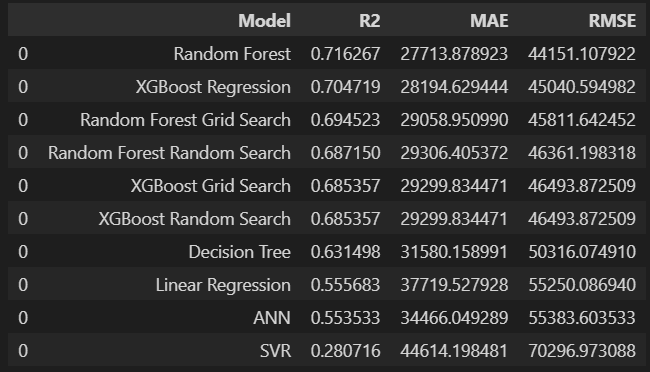
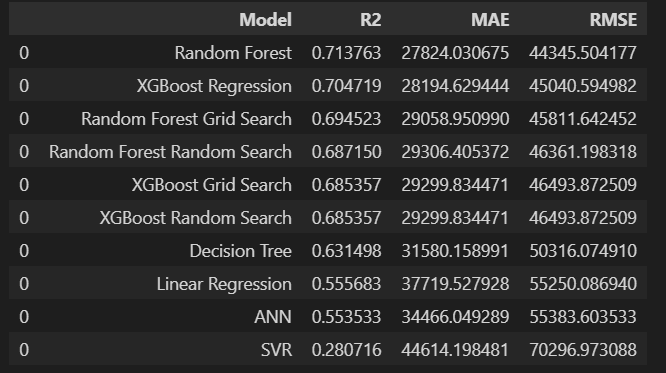

### Floresta Aleatória

In [19]:
from sklearn.ensemble import RandomForestRegressor 
forest_reg = RandomForestRegressor(n_estimators=110, criterion="squared_error", min_samples_split=10)
forest_reg.fit(x_train, y_train.values.ravel())

RandomForestRegressor(min_samples_split=10, n_estimators=110)

### XGBoost Regressor

In [20]:
import xgboost as xg
xgb_reg = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 60, seed=123, booster='dart')
xgb_reg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=60, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Medidas de desempenho

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
def printPerformanceMeasures(models):
    y_true = preco_real
    tableModels = pd.DataFrame(columns=['Model','R2', 'MAE', 'RMSE'])
    for name, model in models.items():
        y_pred = model.predict(test)
        line = pd.Series([name, r2_score(y_true, y_pred),
                          mean_absolute_error(y_true, y_pred),
                          np.sqrt(mean_squared_error(y_true, y_pred))],
                         index=tableModels.columns)
        tableModels = pd.concat([tableModels, pd.DataFrame([line])])
    tableModels = tableModels.sort_values(by='RMSE', ascending=True)
    return tableModels

In [22]:
models = {"Random Forest": forest_reg, "XGBoost Regression": xgb_reg}
printPerformanceMeasures(models)

,Model,R2,MAE,RMSE
0,Random Forest,0.715254,27728.957835,44229.810616
0,XGBoost Regression,0.704719,28194.629444,45040.594982


Houve interesse em combinar os modelos e verificar se eles seriam melhores combinados, a combinação foi feita por média simples, e resultados melhores foram obtidos.

In [23]:
class combinedModelsMean:
    def __init__() -> None:
        return 0
    def predict(data):
       return (xgb_reg.predict(data)+forest_reg.predict(data))/2

In [24]:
models = {"Random Forest": forest_reg, "XGBoost Regression": xgb_reg, "Combined Models(Mean)": combinedModelsMean}
printPerformanceMeasures(models)

,Model,R2,MAE,RMSE
0,Combined Models(Mean),0.722491,27251.790796,43664.132274
0,Random Forest,0.715254,27728.957835,44229.810616
0,XGBoost Regression,0.704719,28194.629444,45040.594982


## Gerando previsões.

É necessário seguir os mesmos passos dos dados de treino, porém o pipeline facilitará esse trabalho. Lembrando que a função "QualiNum" não pode mais ser utilizada, pois os dados de teste são diferentes dos dados de treino. Em vez disso, deve-se utilizar a função para converter as colunas 'modelo', 'versao' e 'cidade_vendedor' em valores numéricos. Isso gerará um padrão diferente do conjunto de treinamento. As colunas geradas e suas respectivas chaves serão usadas para atribuir o mesmo valor às chaves iguais nos dados de teste.

In [25]:
test = pd.read_csv('./cars_test.csv', encoding='utf-16', sep='\t')

In [26]:
def qualiNum_test(key, value, key2):
    dict_ = dict(zip(key,value))
    value2 = [dict_.get(key, None) for key in key2]
    return value2

In [27]:
modelo = qualiNum_test(data_ref['modelo_object'], data_ref['modelo'],test['modelo']) 
versao = qualiNum_test(data_ref['versao'], data_ref['versao'],test['versao']) 
cidade_vendedor = qualiNum_test(data_ref['cidade_vendedor'], data_ref['cidade_vendedor'],test['cidade_vendedor']) 

In [28]:
test['modelo'] = modelo
test['versao'] = versao
test['cidade_vendedor'] = cidade_vendedor

In [29]:
test_pred = pd.DataFrame(fullPipeline.transform(test), columns=fullPipeline.get_feature_names_out())


In [30]:
test_pred.drop(nan_list, axis=1, inplace=True)
test_pred

,quanti__num_fotos,quanti__ano_de_fabricacao,quanti__ano_modelo,quanti__hodometro,quanti__num_portas,quanti__modelo,quanti__versao,quanti__cidade_vendedor,quali__marca_ALFA ROMEO,quali__marca_AUDI,...,quali__troca_False,quali__troca_True,quali__elegivel_revisao_False,quali__dono_aceita_troca_Aceita troca,quali__veiculo_único_dono_Único dono,quali__revisoes_concessionaria_Todas as revisões feitas pela concessionária,quali__ipva_pago_IPVA pago,quali__veiculo_licenciado_Licenciado,quali__garantia_de_fábrica_Garantia de fábrica,quali__revisoes_dentro_agenda_Todas as revisões feitas pela agenda do carro
0,-0.664673,1.040922,1.193454,-1.171526,0.174568,0.425201,-0.403578,-0.300755,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,0.591189,-0.737561,-0.670707,0.710107,0.925355,2.411459,-0.500547
1,2.212866,1.040922,1.193454,-0.164009,-5.756529,-0.379056,-0.403578,-0.300755,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,0.591189,1.355821,-0.670707,0.710107,0.925355,-0.414687,-0.500547
2,-0.664673,0.306475,0.445874,-0.795770,0.174568,0.626265,-0.403578,-0.300755,-0.015924,4.027134,...,0.452577,-0.452577,0.0,0.591189,-0.737561,-0.670707,0.710107,-1.080666,-0.414687,-0.500547
3,1.637358,0.551291,0.819664,-1.027744,0.174568,-0.405865,-0.403578,-0.300755,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,0.591189,1.355821,-0.670707,0.710107,0.925355,-0.414687,-0.500547
4,-0.664673,0.551291,0.445874,0.113445,0.174568,-0.687354,-0.403578,-0.300755,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,0.591189,-0.737561,-0.670707,0.710107,0.925355,-0.414687,-0.500547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9857,-0.664673,0.061660,0.072084,-0.412977,0.174568,-0.553312,-0.403578,-0.300755,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,-1.691508,-0.737561,-0.670707,0.710107,0.925355,-0.414687,-0.500547
9858,1.925112,0.061660,-0.301706,-0.432244,0.174568,-0.057353,-0.403578,-0.300755,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,0.591189,-0.737561,-0.670707,-1.408238,-1.080666,-0.414687,-0.500547
9859,-0.664673,0.796106,1.193454,-1.130687,0.174568,-0.298630,-0.403578,-0.300755,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,-1.691508,1.355821,1.490965,0.710107,-1.080666,2.411459,-0.500547
9860,-0.376919,0.306475,0.072084,-0.132081,0.174568,-0.191396,-0.403578,-0.300755,-0.015924,-0.248316,...,0.452577,-0.452577,0.0,0.591189,1.355821,-0.670707,0.710107,0.925355,-0.414687,-0.500547


In [31]:
previsao = combinedModelsMean.predict(test_pred)

In [32]:
reg_submission = pd.DataFrame({'id': test['id'], 'preco': previsao})
reg_submission

,id,preco
0,13518783164498355150900635905895481162,71495.748305
1,299896161723793383246777788797566040330,89277.633295
2,316180649972302128246133616457018378621,216345.623404
3,222527157104148385909188217274642813298,122746.549642
4,160460343059850745858546502614838368036,106757.340388
...,...,...
9857,270530958308663978454359593206239054667,100522.244118
9858,35444226755331218706378362485070904721,251978.045663
9859,151927592621490440610866139377092833936,117728.521184
9860,118047837484645467440786911677256539035,101901.662437


In [40]:
reg_submission.to_csv('predicted.csv', index=False, encoding='utf-16', sep='\t')